#### Create population netcdf from GeoTIFF

In [66]:
import xarray as xr
import numpy as np
import xesmf as xe
import gdal
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize, ListedColormap

In [82]:
# read in population count
path = '/nfs/a68/earlacoa/population/count/v4.11/2020/'
population_tif = gdal.Open(
    path + 'gpw_v4_population_count_rev11_2020_15_min.tif'
)
population_count = population_tif.ReadAsArray()

# transform lat and lon
geo_transform = population_tif.GetGeoTransform()
population_x = np.linspace(
    geo_transform[0], 
    geo_transform[0] + geo_transform[1] * population_count.shape[1], 
    population_count.shape[1]
)
population_y = np.linspace(
    geo_transform[3], 
    geo_transform[3] + geo_transform[5] * population_count.shape[0], 
    population_count.shape[0]
)

# 2d mesh lat and lon
population_xx, population_yy = np.meshgrid(population_x, population_y)

# replace negative fill values
population_count[population_count < 0] = 0.0

In [83]:
pop = xr.DataArray(
    population_count, 
    dims=('lat', 'lon'), 
    coords={
        'lat': population_y, 
        'lon': population_x
    }
)

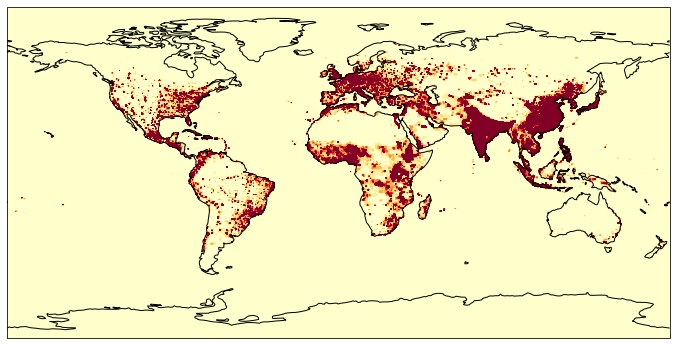

In [92]:
xx, yy = np.meshgrid(pop.lon.values, pop.lat.values)

fig = plt.figure(1, figsize=(10, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
norm = Normalize(vmin=0, vmax=90000)
cmap = ListedColormap(['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026'])
im = ax.contourf(
    xx, yy, 
    pop.values, 
    (0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100_000_000), 
    cmap=cmap, norm=norm, 
    transform=ccrs.PlateCarree()
)
fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 
plt.show()

In [99]:
pop.sum()

<xarray.DataArray ()>
array(7.969445e+09, dtype=float32)

In [104]:
pop = pop.rename('pop')

In [108]:
pop.to_netcdf(path + 'gpw_v4_population_count_rev11_2020_0.25deg.nc')

In [94]:
ds = xr.Dataset(
    {'lat': (['lat'], np.arange(-60, 85, 0.25)), 
     'lon': (['lon'], np.arange(-180, 180, 0.25)),}
)
regridder = xe.Regridder(pop, ds, 'bilinear')

Overwrite existing file: bilinear_720x1440_580x1440.nc 
 You can set reuse_weights=True to save computing time.


In [95]:
pop_regrid = regridder(pop)

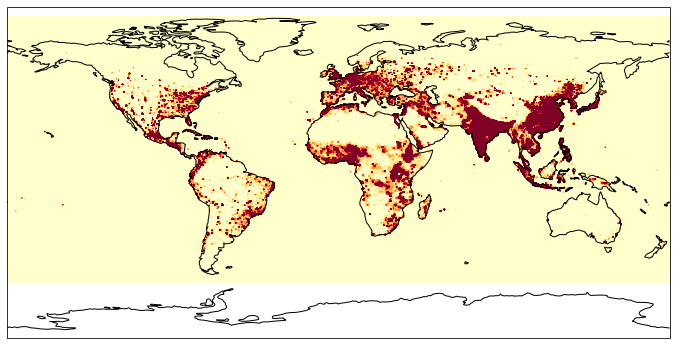

In [96]:
xx, yy = np.meshgrid(pop_regrid.lon.values, pop_regrid.lat.values)

fig = plt.figure(1, figsize=(10, 10))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
ax.coastlines()
norm = Normalize(vmin=0, vmax=90000)
cmap = ListedColormap(['#ffffcc', '#ffeda0', '#fed976', '#feb24c', '#fd8d3c', '#fc4e2a', '#e31a1c', '#bd0026', '#800026'])
im = ax.contourf(
    xx, yy, 
    pop_regrid.values, 
    (0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100_000_000), 
    cmap=cmap, norm=norm, 
    transform=ccrs.PlateCarree()
)
fig.canvas.draw()
gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 
plt.show()

In [98]:
pop_regrid.sum()

<xarray.DataArray ()>
array(7.98604758e+09)

In [105]:
pop_regrid = pop_regrid.rename('pop')

In [109]:
pop_regrid.to_netcdf(path + 'gpw_v4_population_count_rev11_2020_0.25deg_crop.nc')